In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
from matplotlib import pyplot

# 2.Understanding Data
<a class="anchor" id="2"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In [3]:
df=pd.read_csv('input/Admission_Predict_Ver1.1.csv')

Taking a look at our dataset for understanding

In [4]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Serial No.,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.0,10.00
GRE Score,337.00,324.00,316.00,322.00,314.00,330.00,321.00,308.00,302.0,323.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00,115.00,109.00,101.00,102.0,108.00
University Rating,4.00,4.00,3.00,3.00,2.00,5.00,3.00,2.00,1.0,3.00
SOP,4.50,4.00,3.00,3.50,2.00,4.50,3.00,3.00,2.0,3.50
LOR,4.50,4.50,3.50,2.50,3.00,3.00,4.00,4.00,1.5,3.00
CGPA,9.65,8.87,8.00,8.67,8.21,9.34,8.20,7.90,8.0,8.60
Research,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.0,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65,0.90,0.75,0.68,0.5,0.45


In [5]:
df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

The column name `Chance of Admit` had a space at the end so I renamed it

In [6]:
l = df.columns
print('The columns are: ',l)

The columns are:  Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')


In [7]:
print(df.isnull().sum())
print('\n\nNo null values')

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


No null values


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Serial No.,500.0,250.50000,144.481833,1.00,125.7500,250.50,375.25,500.00
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


The above table gives us some intuition about all the columns and and some of their statistics

### Outlier Detection

In [9]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
outliers_to_drop=detect_outliers(df,2,['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research'])

Since outliers can have a dramatic effect on the prediction (especially for regression problems), I chose to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research). Then, i considered outliers as rows that have at least two outlied numerical values

In [10]:
df.loc[outliers_to_drop] # Show the outliers rows

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


There are no outliers because all the values are inside a fixed range and none of them go lower/beyond that range which therefore produces no outliers

In [11]:
cols=df.drop(labels='Serial No.',axis=1)
cols.head().T

,0,1,2,3,4
GRE Score,337.00,324.00,316.00,322.00,314.00
TOEFL Score,118.00,107.00,104.00,110.00,103.00
University Rating,4.00,4.00,3.00,3.00,2.00
SOP,4.50,4.00,3.00,3.50,2.00
LOR,4.50,4.50,3.50,2.50,3.00
CGPA,9.65,8.87,8.00,8.67,8.21
Research,1.00,1.00,1.00,1.00,0.00
Chance of Admit,0.92,0.76,0.72,0.80,0.65


# 3.Data Analysis
<a class="anchor" id="3"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

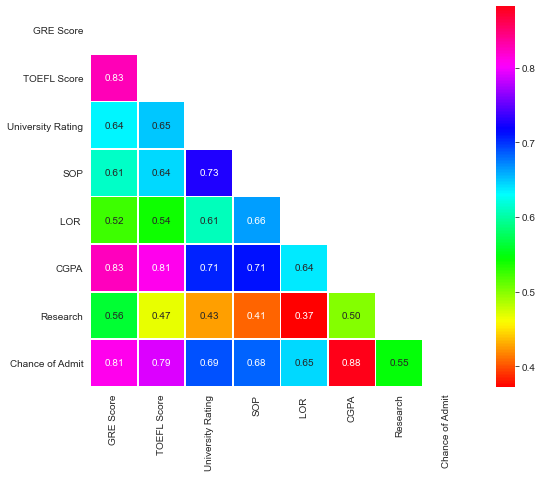

In [12]:
corr = cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr,mask=mask,square=True,annot=True,fmt='0.2f',linewidths=.8,cmap="hsv")


Here we can see that the chance of admit is highly correlated with CGPA, GRE and TOEFEL scores are also correlated.

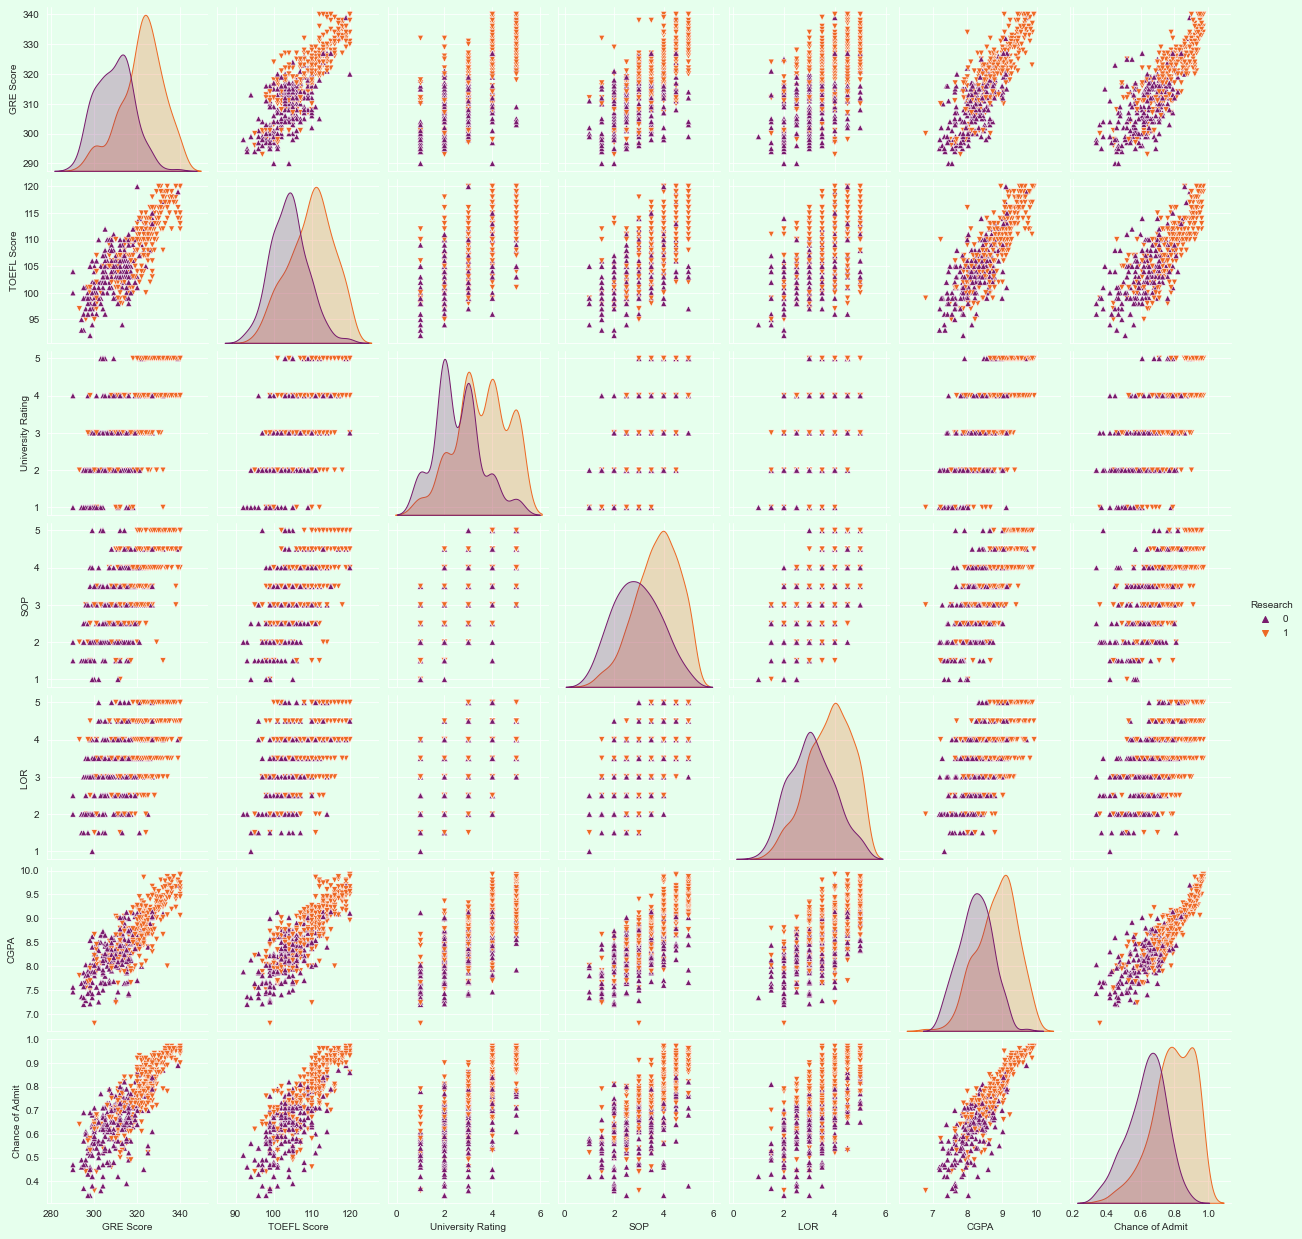

In [13]:
plt.rcParams['axes.facecolor'] = "#e6ffed"
plt.rcParams['figure.facecolor'] = "#e6ffed"
g = sns.pairplot(data=cols,hue='Research',markers=["^", "v"],palette='inferno')

Inferences from the above pairplot:
* GRE score TOEFL score and CGPA all are linearly related to each other 
* Research Students tend to Score higher by all means

<AxesSubplot:xlabel='TOEFL Score', ylabel='Density'>

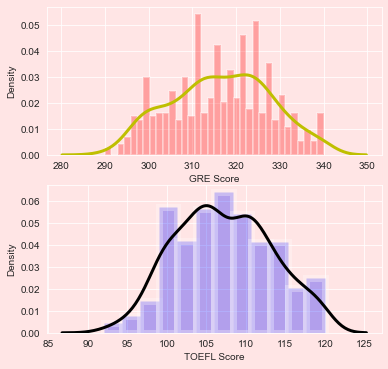

In [14]:
plt.rcParams['axes.facecolor'] = "#ffe5e5"
plt.rcParams['figure.facecolor'] = "#ffe5e5"
plt.figure(figsize=(6,6))
plt.subplot(2, 1, 1)
sns.distplot(df['GRE Score'],bins=34,color='Red',  kde_kws={"color": "y", "lw": 3, "label": "KDE"},hist_kws={"linewidth": 2,"alpha": 0.3 })
plt.subplot(2, 1, 2)
sns.distplot(df['TOEFL Score'],bins=12,color='Blue' ,kde_kws={"color": "k", "lw": 3, "label": "KDE"},hist_kws={"linewidth": 7,"alpha": 0.3 })

From the above 2 graphs its clear that people tend to score above 310 in GRE and above 100 in TOEFL

<AxesSubplot:xlabel='University Rating', ylabel='CGPA'>

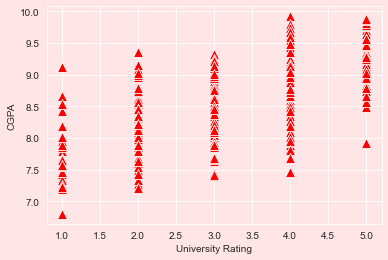

In [15]:
sns.scatterplot(x='University Rating',y='CGPA',data=df,color='Red', marker="^", s=100)

Ratings of university increase with the increase in the CGPA

## Now lets set some cut-off scores and try to analyse scores above the cut-off

In [16]:
co_gre=df[df["GRE Score"]>=300]
co_toefel=df[df["TOEFL Score"]>=100]

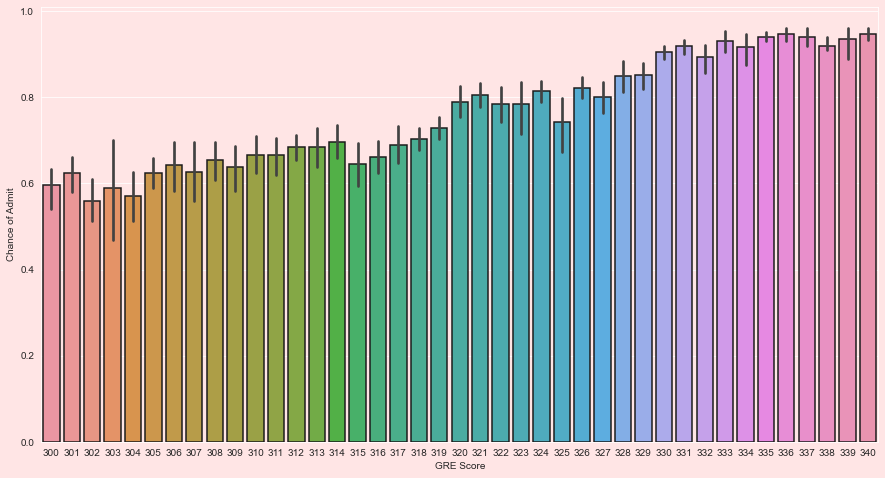

In [17]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='GRE Score',y='Chance of Admit',data=co_gre, linewidth=1.5,edgecolor="0.1")
plt.show()

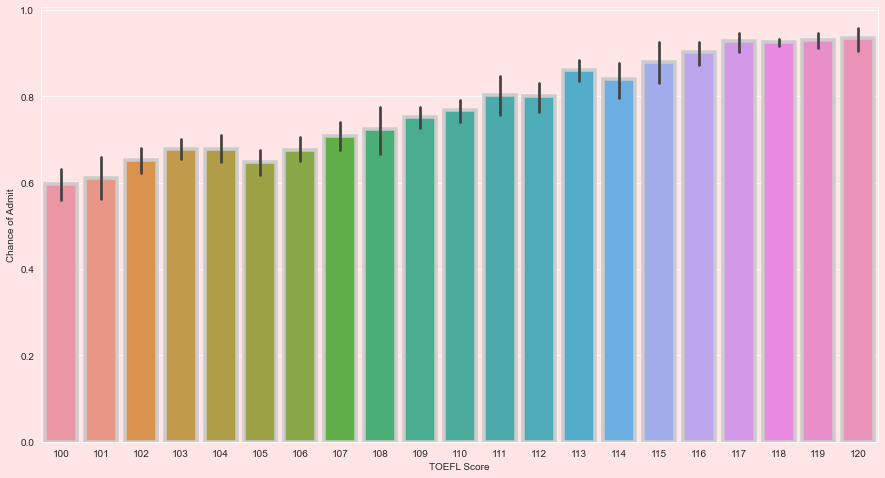

In [18]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='TOEFL Score',y='Chance of Admit',data=co_toefel, linewidth=3.5,edgecolor="0.8")
plt.show()

The above two graphs make it clear that higher the Scores better the chance of admit

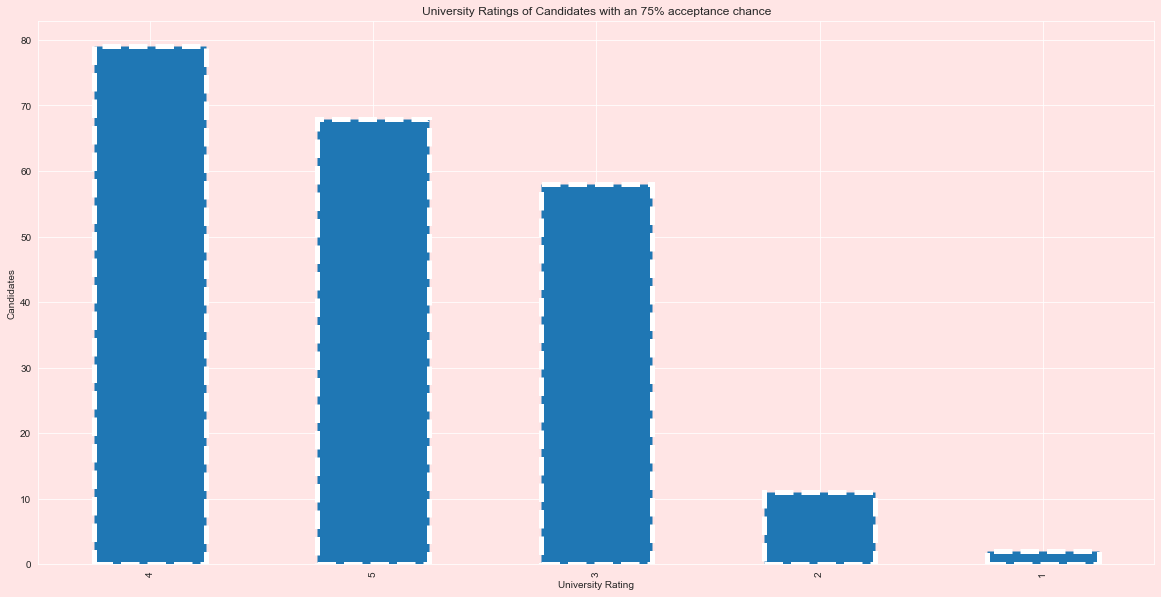

In [19]:
s = df[df["Chance of Admit"] >= 0.75]["University Rating"].value_counts().head(5)
plt.title("University Ratings of Candidates with an 75% acceptance chance")
s.plot(kind='bar',figsize=(20, 10),linestyle='dashed',linewidth=5)
plt.xlabel("University Rating")
plt.ylabel("Candidates")
plt.show()

In [20]:
print("Average GRE Score :{0:.2f} out of 340".format(df['GRE Score'].mean()))
print('Average TOEFL Score:{0:.2f} out of 120'.format(df['TOEFL Score'].mean()))
print('Average CGPA:{0:.2f} out of 10'.format(df['CGPA'].mean()))
print('Average Chance of getting admitted:{0:.2f}%'.format(df['Chance of Admit'].mean()*100))

Average GRE Score :316.47 out of 340
Average TOEFL Score:107.19 out of 120
Average CGPA:8.58 out of 10
Average Chance of getting admitted:72.17%


## Lets check out the toppers

In [21]:
toppers=df[(df['GRE Score']>=330) & (df['TOEFL Score']>=115) & (df['CGPA']>=9.5)].sort_values(by=['Chance of Admit'],ascending=False)
toppers

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
202,203,340,120,5,4.5,4.5,9.91,1,0.97
143,144,340,120,4,4.5,4.0,9.92,1,0.97
24,25,336,119,5,4.0,3.5,9.80,1,0.97
203,204,334,120,5,4.0,5.0,9.87,1,0.97
213,214,333,119,5,5.0,4.5,9.78,1,0.96
385,386,335,117,5,5.0,5.0,9.82,1,0.96
148,149,339,116,4,4.0,3.5,9.80,1,0.96
81,82,340,120,4,5.0,5.0,9.50,1,0.96
496,497,337,117,5,5.0,5.0,9.87,1,0.96
23,24,334,119,5,5.0,4.5,9.70,1,0.95


# 4.Modelling
<a class="anchor" id="4"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

Preparing the data for Regression 

In [22]:
# reading the dataset
df = pd.read_csv("../input/Admission_Predict.csv",sep = ",")

# it may be needed in the future.
serialNo = df["Serial No."].values

df.drop(["Serial No."],axis=1,inplace = True)

df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

FileNotFoundError: [Errno 2] No such file or directory: '../input/Admission_Predict.csv'

In [23]:
X=df.drop('Chance of Admit',axis=1)
y=df['Chance of Admit']

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Normalisation works slightly better for Regression.
X_norm=preprocessing.normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X_norm,y,test_size=0.20,random_state=101)

In [25]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,mean_squared_error

## Regression
<a class="anchor" id="4.1"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In [26]:
regressors=[['Linear Regression :',LinearRegression()],
       ['Decision Tree Regression :',DecisionTreeRegressor()],
       ['Random Forest Regression :',RandomForestRegressor()],
       ['Gradient Boosting Regression :', GradientBoostingRegressor()],
       ['Ada Boosting Regression :',AdaBoostRegressor()],
       ['Extra Tree Regression :', ExtraTreesRegressor()],
       ['K-Neighbors Regression :',KNeighborsRegressor()],
       ['Support Vector Regression :',SVR()]]
reg_pred=[]
print('Results...\n')
for name,model in regressors:
    model=model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    rms=np.sqrt(mean_squared_error(y_test, predictions))
    reg_pred.append(rms)
    print(name,rms)

Results...

Linear Regression : 0.07552799978031202
Decision Tree Regression : 0.11523888232710346
Random Forest Regression : 0.07677759959779933
Gradient Boosting Regression : 0.07797512515255604
Ada Boosting Regression : 0.08643552021413789
Extra Tree Regression : 0.07547348872286212
K-Neighbors Regression : 0.11036629920405958
Support Vector Regression : 0.11781030062139436


In [27]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression','Gradient Boosting Regression', 'Ada Boosting Regression','Extra Tree Regression' ,'K-Neighbors Regression', 'Support Vector Regression' ]
x_ax=reg_pred

<AxesSubplot:>

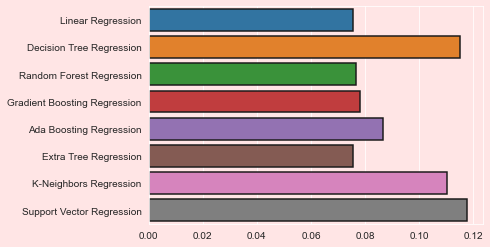

In [28]:
sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.1")

## Classification
<a class="anchor" id="4.2"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >        Back to the table of contents</a>

In [29]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=101)

In [30]:
#If Chance of Admit greater than 80% we classify it as 1
y_train_c = [1 if each > 0.8 else 0 for each in y_train]
y_test_c  = [1 if each > 0.8 else 0 for each in y_test]

In [31]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Random Forest Classification :',RandomForestClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gausian Naive Bayes :',GaussianNB()]]
cla_pred=[]
for name,model in classifiers:
    model=model
    model.fit(X_train,y_train_c)
    predictions = model.predict(X_test)
    cla_pred.append(accuracy_score(y_test_c,predictions))
    print(name,accuracy_score(y_test_c,predictions))

Logistic Regression : 0.87
Decision Tree Classification : 0.91
Random Forest Classification : 0.89
Gradient Boosting Classification : 0.9
Ada Boosting Classification : 0.9
Extra Tree Classification : 0.92
K-Neighbors Classification : 0.87
Support Vector Classification : 0.7
Gausian Naive Bayes : 0.89


In [32]:
y_ax=['Logistic Regression' ,
      'Decision Tree Classifier',
      'Random Forest Classifier',
      'Gradient Boosting Classifier',
      'Ada Boosting Classifier',
      'Extra Tree Classifier' ,
      'K-Neighbors Classifier',
      'Support Vector Classifier',
       'Gaussian Naive Bayes']
x_ax=cla_pred

Text(0.5, 0, 'Accuracy')

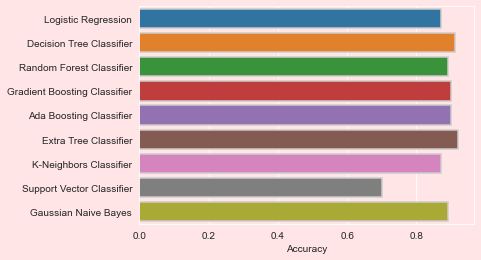

In [33]:
sns.barplot(x=x_ax,y=y_ax,linewidth=1.5,edgecolor="0.8")
plt.xlabel('Accuracy')

So the winner in Regression is : **Linear Regression**


And the winner in Classification is : **Extra Tree Classifier**

<font color="chocolate" size=+2.5><b>My Other Kernels</b></font>

Click on the button to view kernel...


<a href="https://www.kaggle.com/nitindatta/fifa-in-depth-analysis-with-linear-regression" class="btn btn-success" style="color:white;">FIFA In-Depth Analysis</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-1" class="btn btn-success" style="color:white;">Ensemble Learning Part 1</a><br><br>

<a href="https://www.kaggle.com/nitindatta/ensemble-learning-part-2" class="btn btn-success" style="color:white;">Ensemble Learning Part 2</a><br><br>

<a href="https://www.kaggle.com/nitindatta/students-performance-in-exams-eda-in-depth" class="btn btn-success" style="color:white;">Students performance in Exams- EDA in depth 📊📈</a><br><br>

<a href="https://www.kaggle.com/nitindatta/pulmonary-embolism-dicom-preprocessing-eda" class="btn btn-success" style="color:white;">🩺Pulmonary Embolism Dicom preprocessing & EDA🩺</a><br><br>

<a href="https://www.kaggle.com/nitindatta/first-kaggle-submission" class="btn btn-success" style="color:white;">Titanic: Machine Learning from Disaster</a><br><br>

<a href="https://www.kaggle.com/nitindatta/graduate-admission-chances" class="btn btn-success" style="color:white;">📖 Graduate Admission Chances 📕 📔</a><br><br>

<a href="https://www.kaggle.com/nitindatta/flower-classification-augmentations-eda" class="btn btn-success" style="color:white;">Flower_Classification+Augmentations+EDA</a><br><br>

<a href="https://www.kaggle.com/nitindatta/storytelling-with-gwd-pre-print-data" class="btn btn-success" style="color:white;">Storytelling with GWD pre_print data</a><br><br>


### If these kernels impress you,give them an <font size="+2" color="red"><b>Upvote</b></font>.<br>

<a href="#top" class="btn btn-primary" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>